Lista de Exercícios - Machine Learning

Raul Rezende Bassi

In [1]:
#Antes de começar a resolver os exercícios, vou instalar algumas bibliotecas básicas do Python
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import norm
from scipy import stats
%matplotlib inline
from mlxtend.regressor import StackingCVRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split



from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV

from google.colab import files
import io
from google.colab import drive
drive.mount('drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
# Para submeter todos os datasets de uma vez
df = pd.read_csv('/content/drive/MyDrive/archive/train.csv')
mat = pd.read_csv('/content/drive/MyDrive/archive/student-mat.csv')
por = pd.read_csv('/content/drive/MyDrive/archive/student-por.csv')

# **EXERCÍCIO 1**

Utilizando o notebook "linear-regularized.ipynb", disponível no repositório do curso conseguimos em aula uma acurácia em torno de 8-9% para previsão de preços de imóveis.

Usando apenas os modelos vistos até aqui - isto é, Regressão Linear, Ridge e Elastic Net - o seu desafio será aumentar a acurácia dos modelos, conforme medido pelo medida "MAPE" (Mean Absolute Percentage Error).

Para isso, você deverá trabalhar no pré-tratamento de dados, construir novas features e eventualmente eliminar algumas variáveis explicativas de seu dataset original.

No notebook desenvolvido, pede-se que você:

• Justifique todas as escolhas para tratamento de outliers e missing values. Você tentou mais de uma abordagem? Houve impactos relevantes nos resultados?

• Você selecionou um subconjunto de features para treinar os modelos? Qual foi o impacto? Qual foi o critério utilizado para essa seleção de variáveis?

• Você construiu novas features a partir do dataset original? Em caso positivo, justifique suas construções, e avalie se as novas variáveis se mostraram relevantes.

## Análise igual nossa aula

In [3]:
#Antes de mais nada, vou definir o MAPE para depois podermos utilizar essa função 
def mape(Y_actual, Y_Predicted):
    mape = round(np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100, 2)
    return mape

In [4]:
# Aqui replico o que foi feito em aula

train, test = train_test_split(df, test_size=0.3, random_state=7)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], #excluindo ID  
                      test.loc[:,'MSSubClass':'SaleCondition'])) #e SalePrice

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

In [5]:
#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])
print("MAPE do LR")
print(mape( y_test, np.exp(pred_linear)))

#ridge
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
print("MAPE do ridge")
print(mape( y_test, np.exp(ridge_pred) ))

#ridge, se mudarmos o alpha mudamos a medida do MAPE
ridge_reg = Ridge(alpha = 5) 
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
print("MAPE do ridge com alpha alterado")
print(mape( y_test, np.exp(ridge_pred) ))

MAPE do LR
21.77
MAPE do ridge
9.09
MAPE do ridge com alpha alterado
8.63


##Outro approach

In [6]:
#Agora vou carregar os dados de novo
df1 = pd.read_csv('/content/drive/MyDrive/archive/train.csv')

# Por fim faço uma cópia dos dados originais
df_original = df1

total = df1.isnull().sum().sort_values(ascending=False)

percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
print(missing_data.head(40))


               Total   Percent
PoolQC          1453  0.995205
MiscFeature     1406  0.963014
Alley           1369  0.937671
Fence           1179  0.807534
FireplaceQu      690  0.472603
LotFrontage      259  0.177397
GarageYrBlt       81  0.055479
GarageCond        81  0.055479
GarageType        81  0.055479
GarageFinish      81  0.055479
GarageQual        81  0.055479
BsmtFinType2      38  0.026027
BsmtExposure      38  0.026027
BsmtQual          37  0.025342
BsmtCond          37  0.025342
BsmtFinType1      37  0.025342
MasVnrArea         8  0.005479
MasVnrType         8  0.005479
Electrical         1  0.000685
Id                 0  0.000000
Functional         0  0.000000
Fireplaces         0  0.000000
KitchenQual        0  0.000000
KitchenAbvGr       0  0.000000
BedroomAbvGr       0  0.000000
HalfBath           0  0.000000
FullBath           0  0.000000
BsmtHalfBath       0  0.000000
TotRmsAbvGrd       0  0.000000
GarageCars         0  0.000000
GrLivArea          0  0.000000
GarageAr

In [7]:
missing_data[missing_data['Percent'] > 0.4].index
df1 = df1.drop(
    df1[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']], 1 )

In [8]:
list_to_drop_rows = missing_data[
     (missing_data['Percent'] > 0) & (missing_data['Percent'] < 0.1) ]. index.tolist()
list_to_drop_rows

['GarageYrBlt',
 'GarageCond',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'MasVnrArea',
 'MasVnrType',
 'Electrical']

In [9]:
train_pre_delete_rows = df1
for i in list_to_drop_rows:
    print(i)
    
    df1= df1.drop(df1.loc[df1[i].isnull()].index )

GarageYrBlt
GarageCond
GarageType
GarageFinish
GarageQual
BsmtFinType2
BsmtExposure
BsmtQual
BsmtCond
BsmtFinType1
MasVnrArea
MasVnrType
Electrical


In [10]:
# Aqui farei algumas alterações em algumas Vars

#LotFrontage
df1['LotFrontage'] = df1.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#Garage (no geral, se não há informações vou considerar que a casa não possui garagem)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df1[col] = df1[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df1[col] = df1[col].fillna('None')

#Basement (o mesmo que garagem)

for col in ('BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType2'):
    df1[col] = df1[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df1[col] = df1[col].fillna('None')

In [11]:
#Aqui replico o código 

train, test = train_test_split(df1, test_size=0.3, random_state=7)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], #excluindo ID  
                      test.loc[:,'MSSubClass':'SaleCondition'])) #e SalePrice

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

In [12]:
#Após mexer com algumas variáveis
#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])
print("MAPE do LR")
print(mape( y_test, np.exp(pred_linear)))

#ridge
ridge_reg = Ridge(alpha = 5) 
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
print("MAPE do ridge")
print(mape( y_test, np.exp(ridge_pred) ))

MAPE do LR
19.73
MAPE do ridge
9.01


Como podemos ver, reduzimos o MAPE do LR, porém aumentamos o do Ridge 🧐

Sendo assim, vamos tentar coisas diferentes 😭😭😭

## Mais um approach

In [13]:
# Dividindo em treino e teste
hp = pd.read_csv('/content/drive/MyDrive/archive/train.csv')
train, test = train_test_split(hp, test_size=0.3, random_state=3)

## Olhando os valores nulos

Total_null = train.isnull().sum().sort_values(ascending=False)
Total_null

Percent_null = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
Percent_null.head(20)

PoolQC          99.804305
MiscFeature     96.379648
Alley           94.911937
Fence           81.604697
FireplaceQu     47.455969
LotFrontage     18.003914
GarageYrBlt      5.185910
GarageCond       5.185910
GarageType       5.185910
GarageFinish     5.185910
GarageQual       5.185910
BsmtExposure     3.228963
BsmtQual         3.131115
BsmtCond         3.131115
BsmtFinType2     3.131115
BsmtFinType1     3.131115
MasVnrArea       0.489237
MasVnrType       0.489237
Electrical       0.097847
Id               0.000000
dtype: float64

In [14]:
#Observando se as casas que possuem metragem da piscina tem o valor de qualidade também
hp1 = hp.query('PoolArea > 0')
hp1.info()
print(hp1.shape)
# Se há metragem da piscina, está avaliada sua qualidade também

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 197 to 1423
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7 non-null      int64  
 1   MSSubClass     7 non-null      int64  
 2   MSZoning       7 non-null      object 
 3   LotFrontage    6 non-null      float64
 4   LotArea        7 non-null      int64  
 5   Street         7 non-null      object 
 6   Alley          0 non-null      object 
 7   LotShape       7 non-null      object 
 8   LandContour    7 non-null      object 
 9   Utilities      7 non-null      object 
 10  LotConfig      7 non-null      object 
 11  LandSlope      7 non-null      object 
 12  Neighborhood   7 non-null      object 
 13  Condition1     7 non-null      object 
 14  Condition2     7 non-null      object 
 15  BldgType       7 non-null      object 
 16  HouseStyle     7 non-null      object 
 17  OverallQual    7 non-null      int64  
 18  OverallCo

In [15]:
## Enconding de algumas variáveis 

## Pool quality 

train = train.replace(
    {"PoolQC": {np.nan: 0, 
                  "Fa": 1, 
                  "TA": 2, 
                  "Gd": 3,
                  "Ex": 4}}                
                  )

test = test.replace(
    {"PoolQC": {np.nan: 0, 
                  "Fa": 1, 
                  "TA": 2, 
                  "Gd": 3,
                  "Ex": 4}}                
                  )

In [16]:
## Fence

train = train.replace(
    {"Fence": {np.nan: 0, 
                  "MnWw": 1, 
                  "GdWo": 2, 
                  "MnPrv": 3,
                  "GdPrv": 4}}                
                  )

test = test.replace(
    {"Fence": {np.nan: 0, 
                  "MnWw": 1, 
                  "GdWo": 2, 
                  "MnPrv": 3,
                  "GdPrv": 4}}                
                  )

In [17]:
## Fireplace

train = train.replace(
    {"FireplaceQu": {np.nan: 0, 
                  "Po": 1, 
                  "Fa": 2, 
                  "TA": 3,
                  "Gd": 4,
                  "Ex": 5}}                
                  )

test = test.replace(
    {"FireplaceQu": {np.nan: 0, 
                  "Po": 1, 
                  "Fa": 2, 
                  "TA": 3,
                  "Gd": 4,
                  "Ex": 5}}                
                  )

In [18]:
## LotFrontage vamos adicionar as NaN 

train['LotFrontage'] = train.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [19]:
## Garage variables. Nessas vou zerar usando um código encontrado no kaggle e referenciado na seção abaixo
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

#Para porão a ideia é a mesma, coloquei tudo junto aqui

In [20]:
Total_null = train.isnull().sum().sort_values(ascending=False)
Total_null

Percent_null = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
Percent_null.head(20)

MiscFeature     96.379648
Alley           94.911937
MasVnrType       0.489237
MasVnrArea       0.489237
Electrical       0.097847
KitchenAbvGr     0.000000
GarageType       0.000000
FireplaceQu      0.000000
Fireplaces       0.000000
Functional       0.000000
TotRmsAbvGrd     0.000000
KitchenQual      0.000000
Id               0.000000
GarageYrBlt      0.000000
HalfBath         0.000000
FullBath         0.000000
BsmtHalfBath     0.000000
BsmtFullBath     0.000000
GrLivArea        0.000000
LowQualFinSF     0.000000
dtype: float64

### Agora vou mexer com a "Skewedacity"

In [21]:
#Antes vou dropar as variáveis 
train.drop(['MiscFeature', 'Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'Electrical'], axis=1, inplace=True)
test.drop(['MiscFeature', 'Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'Electrical'], axis=1, inplace=True)

In [22]:
#Aqui confesso que não sei o que acontece, mas usei o código daqui (https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_train = train[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_train[skew_train > 0.5]
skew_index = high_skew.index

for i in skew_index:
    train[i] = boxcox1p(train[i], boxcox_normmax(train[i] + 1))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in test.columns:
    if test[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_test = test[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_test[skew_test > 0.5]
skew_index = high_skew.index

for i in skew_index:
    test[i] = boxcox1p(test[i], boxcox_normmax(test[i] + 1))

In [23]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
472,473,8.489440,RM,8.862503,9.121495,Pave,Reg,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,6,2008,WD,Normal,8.802282
1440,1441,6.340973,RL,13.622897,10.547791,Pave,IR1,Bnk,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,9,2008,WD,Normal,8.936171
730,731,7.521520,RL,9.397694,9.594557,Pave,IR1,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,3,2010,WD,Normal,9.046936
1214,1215,6.752756,RL,12.704045,10.393925,Pave,IR1,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,5,2006,WD,Normal,8.751600
806,807,6.622578,RL,13.263438,10.336395,Pave,Reg,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,10,2006,WD,Normal,8.755534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,790,6.024515,RL,13.711200,10.620308,Pave,IR1,Low,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,7,2007,WD,Normal,8.926524
256,257,6.024515,FV,12.217267,10.206044,Pave,IR1,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,0.000000,0.0,5,2008,WD,Normal,8.979274
968,969,5.661940,RM,10.732192,9.712448,Pave,Reg,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,1.807434,0.0,5,2009,WD,Abnorml,8.055382
952,953,6.752756,RL,11.812719,9.955659,Pave,Reg,Lvl,AllPub,Inside,...,0.0000,0.0,0.0,2.628277,0.0,4,2009,WD,Normal,8.749224


Disclaimer: Alguns códigos foram inspirados nessa análise do Kaggle: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

Além disso, alguns exercícios eu fiz conversando com o aluno Bruno Carneiro, para termos insights, por isso pode haver semelhança no código e na ideia utilizada.

### Modelando

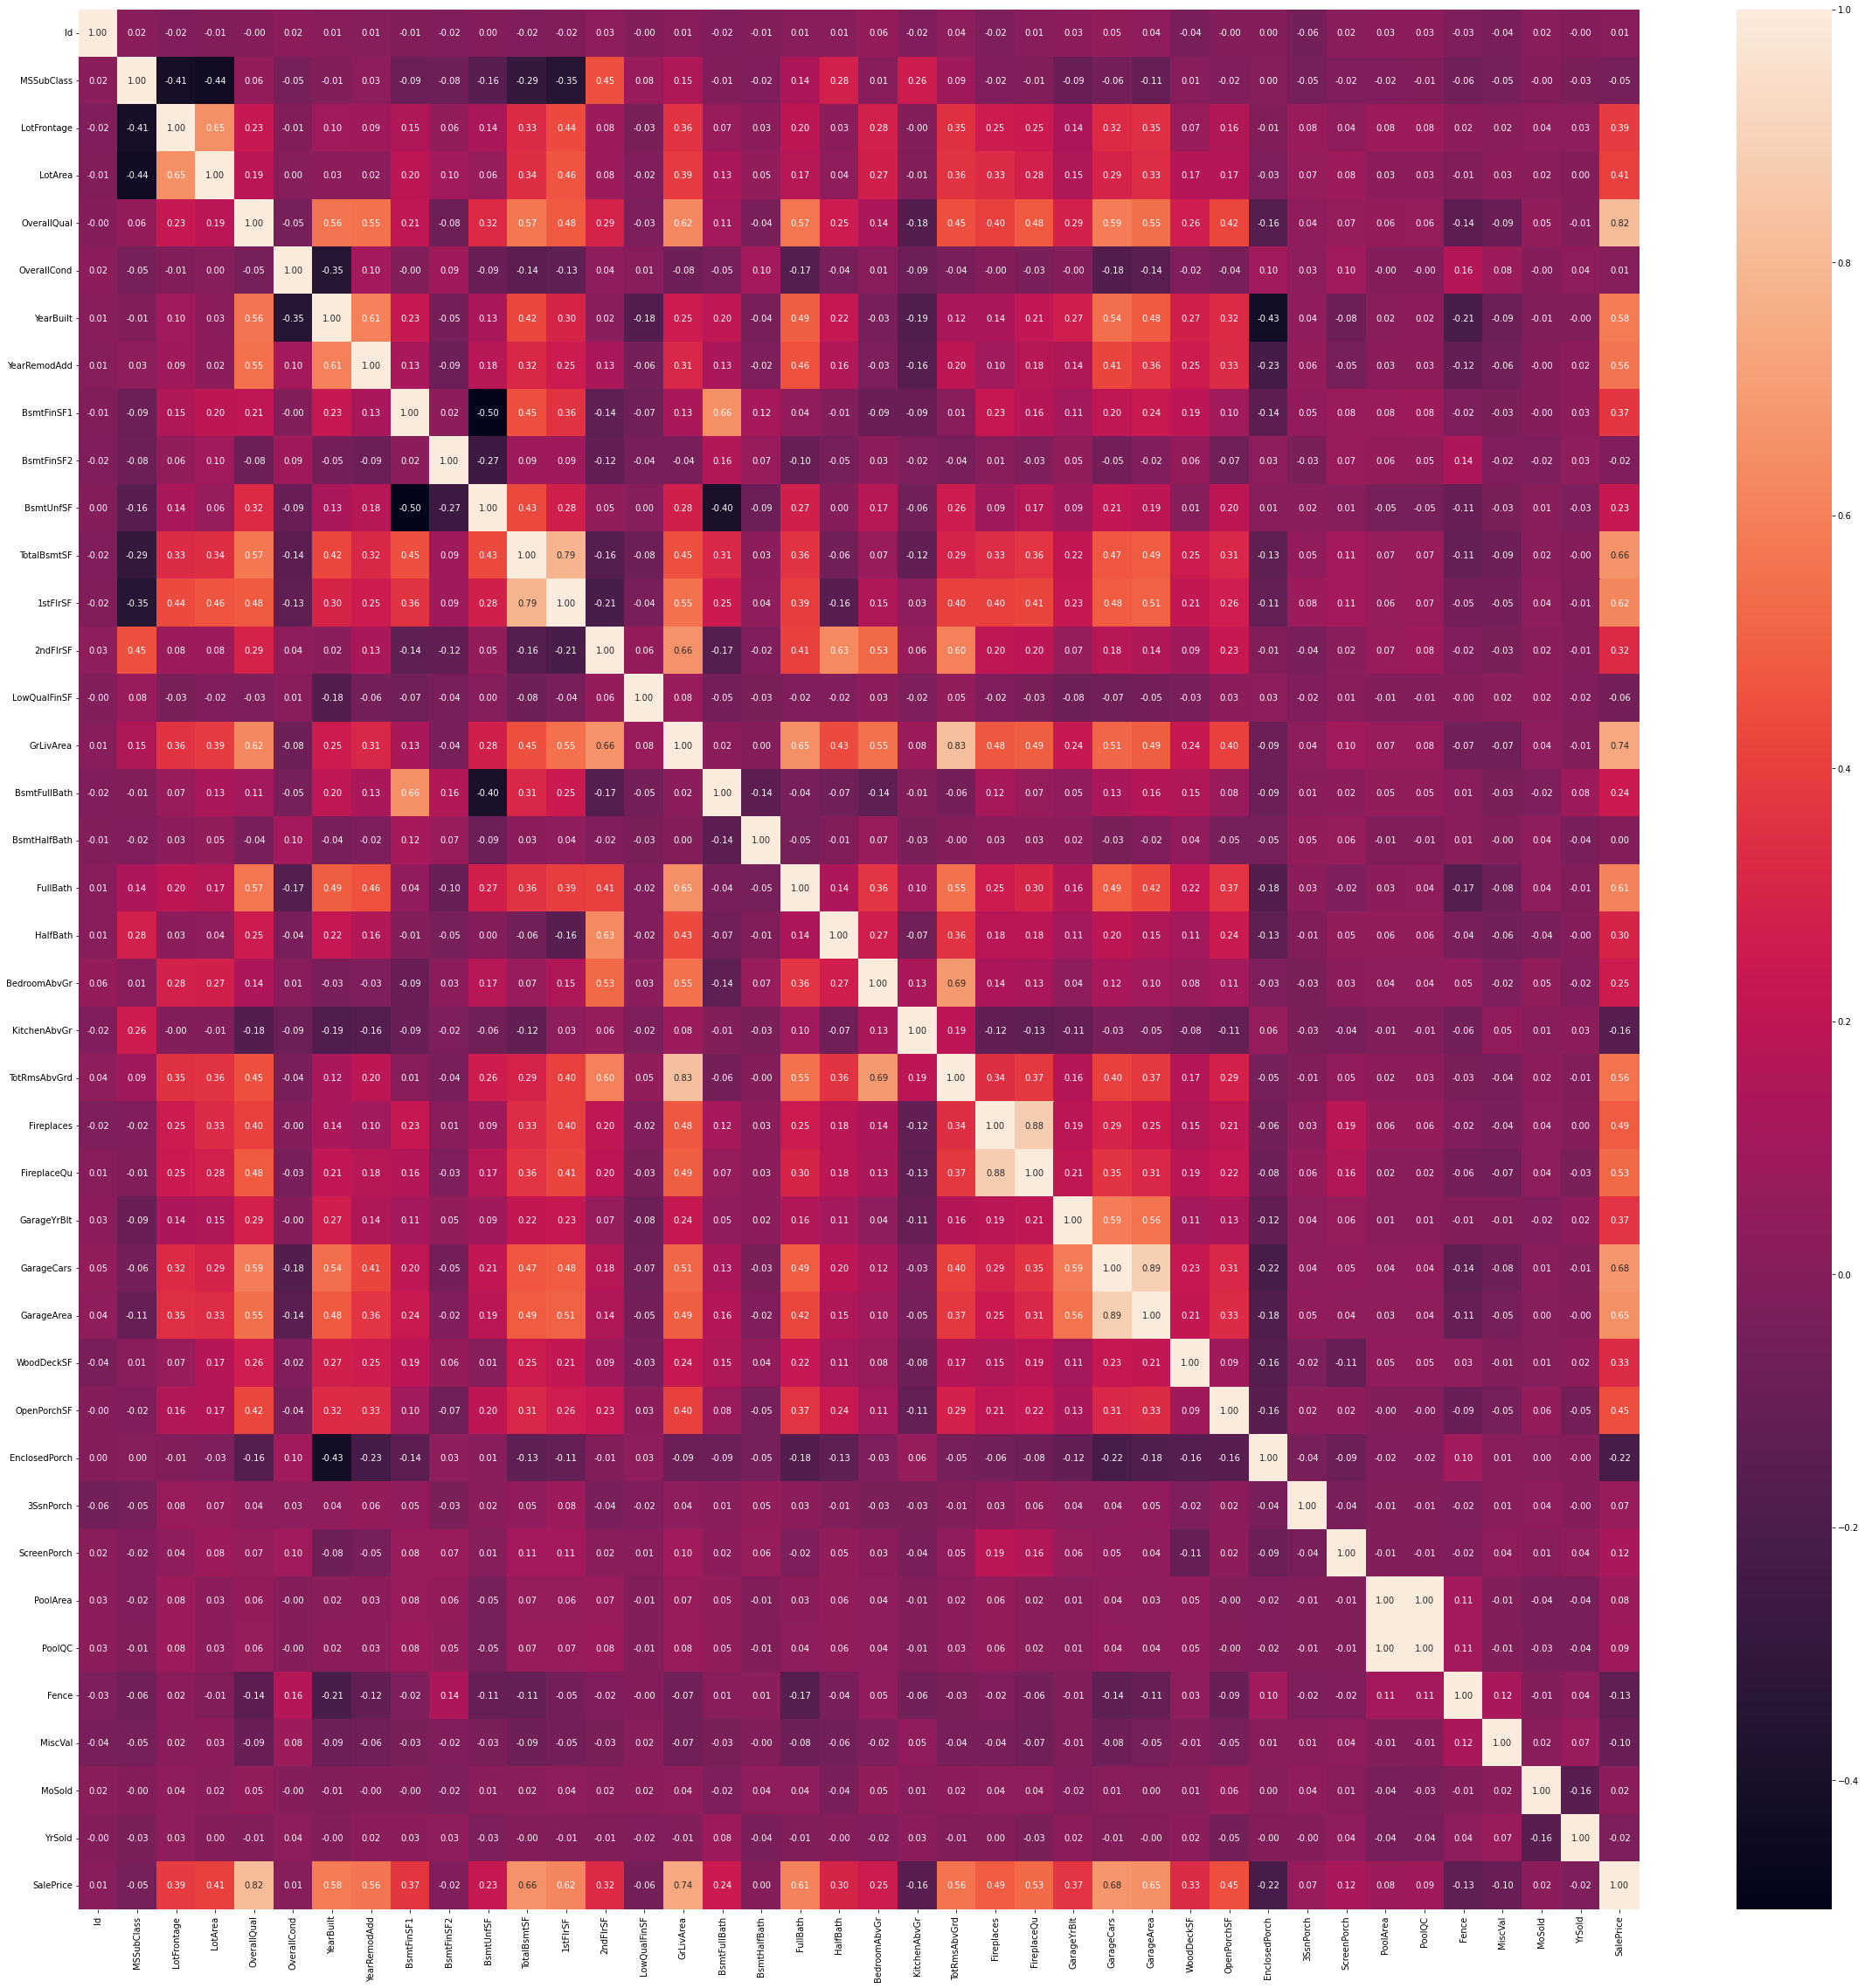

In [24]:
# Primeiro farei uma matriz de correlação para selecionar os parâmetros dos modelos
plt.figure(figsize=(40,40))
sns.heatmap(train.corr(),annot = True,fmt = ".2f",cbar = True)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 472 to 1273
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1022 non-null   int64  
 1   MSSubClass     1022 non-null   float64
 2   MSZoning       1022 non-null   object 
 3   LotFrontage    1022 non-null   float64
 4   LotArea        1022 non-null   float64
 5   Street         1022 non-null   object 
 6   LotShape       1022 non-null   object 
 7   LandContour    1022 non-null   object 
 8   Utilities      1022 non-null   object 
 9   LotConfig      1022 non-null   object 
 10  LandSlope      1022 non-null   object 
 11  Neighborhood   1022 non-null   object 
 12  Condition1     1022 non-null   object 
 13  Condition2     1022 non-null   object 
 14  BldgType       1022 non-null   object 
 15  HouseStyle     1022 non-null   object 
 16  OverallQual    1022 non-null   int64  
 17  OverallCond    1022 non-null   float64
 18  YearBu

In [26]:
#creating matrices for sklearn:
X_train = train
X_test = test
y_train = train.SalePrice
y_test = test.SalePrice

In [27]:
#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])
print("MAPE do LR")
print(mape( y_test, np.exp(pred_linear)))


MAPE do LR
29283.72


Parece que não deu certo 😭

E se eu selecionar algumas features?

In [28]:
#creating matrices for sklearn:
X_train = train[['LotArea', 'Fence', 'LotFrontage', 'TotalBsmtSF', 'GarageArea', 'FullBath', 'FireplaceQu', 'GrLivArea', 'BedroomAbvGr', '2ndFlrSF']]
X_test = test[['LotArea', 'Fence', 'LotFrontage', 'TotalBsmtSF', 'GarageArea', 'FullBath', 'FireplaceQu', 'GrLivArea', 'BedroomAbvGr', '2ndFlrSF']]
y_train = train.SalePrice
y_test = test.SalePrice

#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
pred_linear = linear_reg.predict(X_test)
print("MAPE do LR")
print(mape( y_test, np.exp(pred_linear)))

MAPE do LR
45278.47


Que loucura, o MAPE, não reduz, provavelmente a escolha de tratar as váriaveis dessa forma não foi uma escolha ótima

# Uma quarta tentativa, baseando em codes do kaggle

Me baseei no código feito por esse usuário: https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [29]:
#Tratamento de Outliers
df = pd.read_csv('/content/drive/MyDrive/archive/train.csv')
train, test = train_test_split(df, test_size=0.3, random_state=7)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [30]:
#log da var que quero prever
train["SalePrice"] = np.log1p(train["SalePrice"])

In [31]:
#tratando missing data
train_n = (train.isnull().sum() / len(train)) * 100
train_n = train_n.drop(train_n[train_n == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_n})
missing_data.head(20)

,Missing Ratio
PoolQC,99.705882
MiscFeature,96.568627
Alley,93.333333
Fence,80.686275
FireplaceQu,46.176471
LotFrontage,18.431373
GarageType,5.882353
GarageYrBlt,5.882353
GarageFinish,5.882353
GarageQual,5.882353


In [32]:
# Fazendo alguns imputs
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train = train.drop(['Utilities'], axis=1)
train["Functional"] = train["Functional"].fillna("Typ")
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
train['MSSubClass'] = train['MSSubClass'].fillna("None")


In [33]:
train_n = (train.isnull().sum() / len(train)) * 100
train_n = train_n.drop(train_n[train_n == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_n})
missing_data.head(20)

,Missing Ratio


In [34]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features: 

There are 265 skewed numerical features to Box Cox transform


 Aqui vou treinar os modelos Lasso, Elastic Net e Ridge na base dividida, vale ressaltar que não uso a base test disponível no Kaggle. Para aplicalos de forma conjunta numa técnica de blending.

In [35]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [36]:
y = train['SalePrice'].reset_index(drop=True)

In [37]:
final = pd.get_dummies(train).reset_index(drop=True)
X = final.iloc[:len(y), :]
X_sub = final.iloc[len(y):, :]

In [38]:
elastic_model_full_data = ENet.fit(X, y)

lasso_model_full_data = lasso.fit(X, y)

ridge_model_full_data = ridge.fit(X, y)

Blending os modelos

Assim como: https://zcczhang.github.io/projects/house_pice_prediction

In [39]:
def blend_models_predict(X):
    return ((0.35 * elastic_model_full_data.predict(X)) + \
            (0.25 * lasso_model_full_data.predict(X)) + \
            (0.4 * ridge_model_full_data.predict(X)))

In [40]:
print('MAPE score:')
print(mape(y, blend_models_predict(X)))

MAPE score:
0.0


# **EXERCÍCIO 2**

Acesse o seguinte dataset do kaggle: 

https://www.kaggle.com/datasets/uciml/student-alcohol-consumption?datasetId=251sortBy=voteCount

Os dados contêm informações sobre o desempenho de estudantes do ensino médio
nos cursos de português e matemática. Aqui, o nosso foco não será na previsão em si, mas na utilização de modelos lineares ( e interpretáveis) para determinação dos principais condicionantes do desempenho acadêmico. Em especial, estamos interessados em determinar os impactos do consumo de álcool sobre as notas.

Mais uma vez, foque na utilização de modelos lineares, como regressões regularizadas, vistas até aqui no curso.

Nota: ignore as variáveis G1 e G2. Elas são muito correlacionadas com G3, nossa variável resposta, e sua utilização atrapalharia a identificação dos impactos de interesse.

Mais especificamente, construa um notebook que percorra as seguintes etapas:

• Percorra as etapas usuais de análise exploratória e preparação dos dados. Nesse sentido, avalie e, se necessário, trate a presença de outliers, missing values, observações repetidas e outras questões que possam afetar o aprendizado dos modelos. Justifique todas suas escolhas

• Quais são os principais determinantes para a nota observada? Avalie e interprete os impactos quantitativos das principais variáveis.

• Foque agora na avaliação dos impactos do consumo do álcool sobre o desempenho dos alunos. Quais modificações no seu conjunto de dados você propõe para melhorar essa identificação? E, utilizando tais estratégias, qual a sua avaliação acerca desses impactos?

# Matemática

In [41]:
# Dados já upados
#mat = pd.read_csv("student-mat.csv") 
#por = pd.read_csv("student-por.csv") 

In [42]:
mat_std = mat.std()
por_std = por.std()
mat_mean = mat.mean()
por_mean = por.mean()

In [43]:
#Como não usaremos as variáveis G1 e G2, vou dropar de ambos datasets
mat.drop(["G1", "G2"], axis=1, inplace=True)
por.drop(["G1", "G2"], axis=1, inplace=True)
mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10


In [44]:
#copiando o dataset original
mat_o = mat
por_o = por

In [45]:
#Trabalharei os datasets separadamente, porque quero medir os efeitos individualmente para cada disciplina. Começando por matemática e depois repetindo o processo para português.

#Primeiramente vou ver as dimensões do dataset e ver se existem missing values
print(mat.shape)
print(mat.info())

#Outra visualização como tivemos em aula
total = mat.isnull().sum().sort_values(ascending=False)
percent = (mat.isnull().sum()/mat.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], 
    axis=1, 
    keys=['Total', 'Percent'])
missing_data.head(20)


#Assim conseguimos ver que não existem casos de missing values e também a classe dos objetos

(395, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  

,Total,Percent
school,0,0.0
famsup,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0
famrel,0,0.0
romantic,0,0.0


In [46]:
#Como próximo passo vou tratar os casos duplicados (se houverem)
mat.duplicated().count()

#Não existem valores duplicados

395

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,10


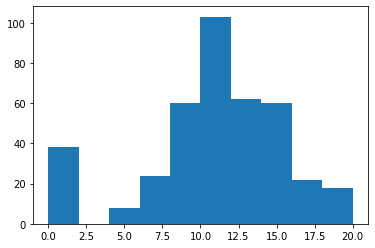

In [47]:
#Agora vamos avaliar se existem outliers, avaliando a distribuição dos nossos dados
plt.hist(mat['G3'], alpha = 1, label='Original Data')
mat['G3'].shape
mat

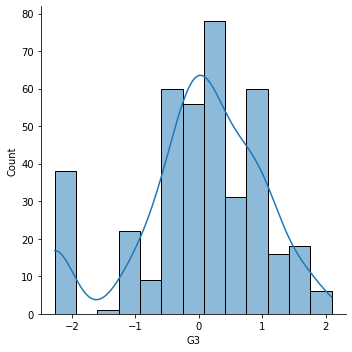

In [48]:
#Agora faremos uma normalização dos dados para poder aplicar a regrade trimming and censoring
mat['G3'] = (mat['G3'] - mat['G3'].mean())/mat['G3'].std()
sns.displot(mat['G3'], kde = True)

In [49]:
#Aqui vou definir o limite tanto para cima quanto para baixo
n_mat = 2

upper_limit = mat['G3'].mean() + n_mat*mat['G3'].std()
lower_limit = mat['G3'].mean() - n_mat*mat['G3'].std()

In [50]:
#TRIMMING

mat_trimmed = mat[
    (mat['G3'] < upper_limit) &
    (mat['G3'] > lower_limit)
]

mat_trimmed.shape

## CENSORING

mat_censored = pd.DataFrame()

mat_censored['G3'] =  np.where(
    mat['G3'] > upper_limit,
        upper_limit,
        np.where(
            mat['G3'] < lower_limit,
            lower_limit,                   
            mat['G3']               
            )
        )

mat_censored.shape

(395, 1)

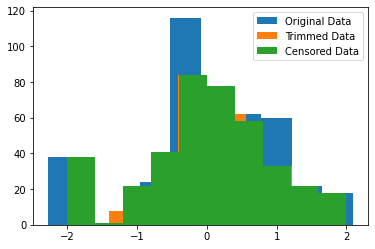

In [51]:
plt.hist(mat['G3'], alpha=1, label='Original Data')
plt.hist(mat_trimmed['G3'], alpha = 1, label='Trimmed Data')
plt.hist(mat_censored['G3'], alpha=1, label = 'Censored Data')

plt.legend(loc='upper right')
plt.show()

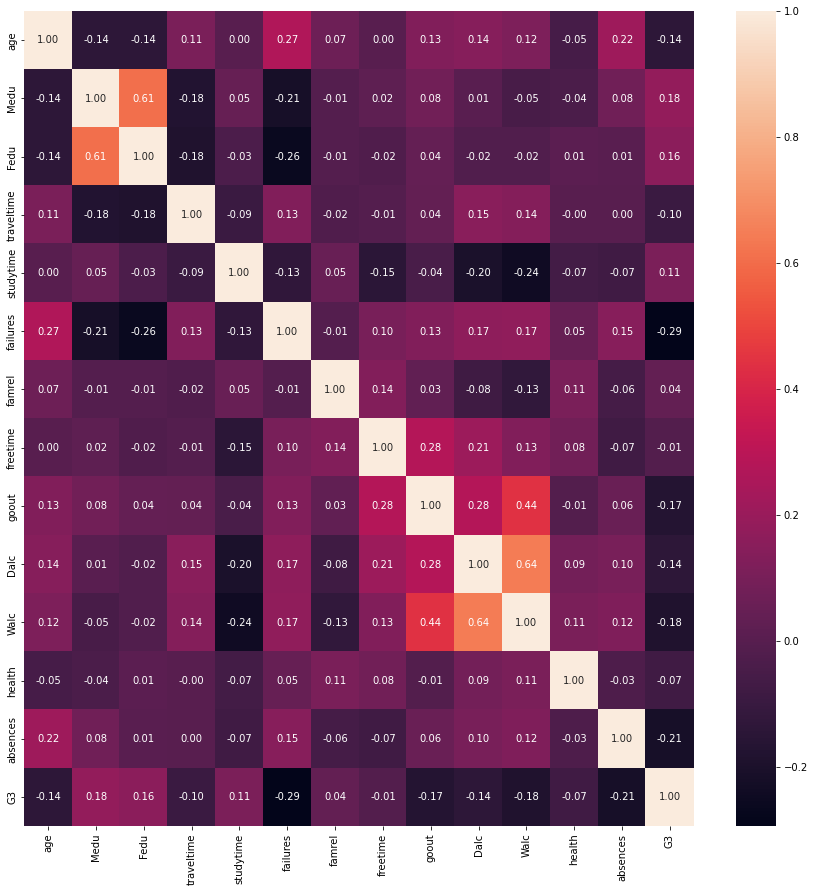

In [52]:
#Usarei a matrix de correlação para avaliar quais variáveis númericas aparentemente tem maior correlação com a variável G3
plt.figure(figsize=(15,15))
sns.heatmap(mat_trimmed.corr(),annot = True,fmt = ".2f",cbar = True)

Aparentemente uma maior educação dos familiares tem correlação positiva com a note final, enquanto ter falhado em outras matérias tem uma correlação negativa.


In [53]:
#mat_1 = pd.get_dummies(mat_trimmed, columns=['internet', 'higher', 'Pstatus', 'sex', 'school'])
#mat_1.select_dtypes(exclude=['object'])

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,9.0
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,16.0
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,7.0
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,10.0


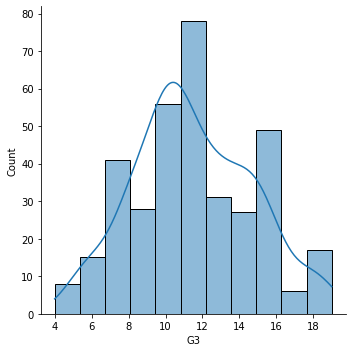

In [54]:
# agora para poder interpretar os resultados é necessário desnormalizar os dados 
mat_n = mat_trimmed
mat_n['G3'] = mat_n['G3']* mat_std['G3'] + mat_mean['G3']

sns.displot(mat_n['G3'], kde = True)
mat_n

In [55]:
#Para avaliar os efeitos do consumo de alcool, primeiro vou juntar as variaveis de consumo durante a semana e durante o final de semana, porque se eu avalair separadamente posso ter problemas de cofounder variables
mat_n['alc'] = mat_n['Dalc'] + mat_n['Walc']

#Agora vou rodar a regressão linear para medir os efeitos do alcool nas notas, vou incluir ainda variaveis como tempo de estudo, idade, e educação dos país
X = mat_n[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = mat_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     9.640
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.23e-08
Time:                        20:39:08   Log-Likelihood:                -895.84
No. Observations:                 356   AIC:                             1804.
Df Residuals:                     350   BIC:                             1827.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0679      0.763     14.501      0.000       9.567      12.569
alc           -0.1953      0.083     -2.346      0.020      -0.359      -0.032
Medu           0.3297      0.186      1.774      0.077      -0.036       0.695
Fedu           0.0785      0.190      0.414      0.679      -0.295       0.452
failures      -1.1121      0.253     -4.388      0.000      -1.611      -0.614
studytime      0.1783      0.202      0.882      0.378      -0.219       0.576
==============================================================================
Omnibus:                        2.250   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                1.866
Skew:                           0.025   Prob(JB):                        0.393
Kurtosis:                       2.649   Cond. No.                         29.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
#após discussão em classe decidi também médir para efeitos de uso de alcool em dias de semana e final de semana, porém não na mesma regressão 
## De semana
X = mat_n[["Dalc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente 
y = mat_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     9.034
Date:                Sun, 15 May 2022   Prob (F-statistic):           4.33e-08
Time:                        20:39:08   Log-Likelihood:                -897.21
No. Observations:                 356   AIC:                             1806.
Df Residuals:                     350   BIC:                             1830.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6783      0.730     14.631      0.000       9.243      12.114
Dalc          -0.3019      0.181     -1.672      0.095      -0.657       0.053
Medu           0.3398      0.187      1.820      0.070      -0.027       0.707
Fedu           0.0705      0.191      0.370      0.712      -0.304       0.445
failures      -1.1453      0.254     -4.512      0.000      -1.645      -0.646
studytime      0.2246      0.201      1.118      0.264      -0.170       0.620
==============================================================================
Omnibus:                        2.835   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.245
Skew:                           0.046   Prob(JB):                        0.326
Kurtosis:                       2.622   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
## De fim de semana
X = mat_n[["Walc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente 
y = mat_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     9.737
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.01e-08
Time:                        20:39:08   Log-Likelihood:                -895.63
No. Observations:                 356   AIC:                             1803.
Df Residuals:                     350   BIC:                             1827.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0769      0.757     14.625      0.000       9.587      12.567
Walc          -0.3144      0.129     -2.436      0.015      -0.568      -0.061
Medu           0.3166      0.186      1.705      0.089      -0.049       0.682
Fedu           0.0859      0.190      0.453      0.651      -0.287       0.459
failures      -1.1188      0.253     -4.428      0.000      -1.616      -0.622
studytime      0.1764      0.202      0.875      0.382      -0.220       0.573
==============================================================================
Omnibus:                        1.907   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.652
Skew:                           0.024   Prob(JB):                        0.438
Kurtosis:                       2.670   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Aparentemente, consumir álcool de semana, tem um efeito negativo nas notas de matemática, apesar de muito baixo, enquanto durante a semana, causa um efeito minimamente positivo.


Com este modelo, é possível perceber que o uso de alcool tem uma relação muito baixa com as notas, porém existem uma associação negativa entre ambos. Vale ressaltar que o fato de haver reprovações passadas tem um impacto negativo muito maior e que o nível de educação da mãe tende a ter um impacto positivo nas notas finais.

In [58]:
#Antes de ir para a análise da matéria de portugês vou adicionar uma variavél dummy para a escola e para o gênero do aluno e rodar novamente o modelo
mat1 = pd.get_dummies(mat_n, columns=['sex', 'school'])

In [59]:
X = mat1[["alc", "Medu", "Fedu", "failures", "studytime", "sex_M", "sex_F", "school_GP", "school_MS"]] ## VAR Independente
y = mat1["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     8.535
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.17e-09
Time:                        20:39:08   Log-Likelihood:                -890.61
No. Observations:                 356   AIC:                             1797.
Df Residuals:                     348   BIC:                             1828.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4784      0.385     14.241      0.000       4.722       6.235
alc           -0.2545      0.085     -2.995      0.003      -0.422      -0.087
Medu           0.2708      0.185      1.464      0.144      -0.093       0.635
Fedu           0.1101      0.188      0.586      0.558      -0.259       0.480
failures      -1.0738      0.251     -4.282      0.000      -1.567      -0.581
studytime      0.3396      0.207      1.640      0.102      -0.068       0.747
sex_M          3.2801      0.257     12.739      0.000       2.774       3.787
sex_F          2.1983      0.258      8.512      0.000       1.690       2.706
school_GP      2.8753      0.283     10.157      0.000       2.319       3.432
school_MS      2.6031      0.343      7.581      0.000       1.928       3.278
==============================================================================
Omnibus:                        2.711   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.238
Skew:                           0.070   Prob(JB):                        0.327
Kurtosis:                       2.638   Cond. No.                     7.91e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.15e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Fazendo uma análise em matemática filtrando os datasets


In [60]:
mat_m = mat_n.query('sex == "M"')
mat_f = mat_n.query('sex == "F"')
mat_gp = mat_n.query('school == "GP"')
mat_ms = mat_n.query('school == "MS"')

In [61]:
X = mat_m[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = mat_m["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     10.78
Date:                Sun, 15 May 2022   Prob (F-statistic):           5.50e-09
Time:                        20:39:08   Log-Likelihood:                -417.28
No. Observations:                 171   AIC:                             846.6
Df Residuals:                     165   BIC:                             865.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6355      0.983     12.856      0.000      10.695      14.576
alc           -0.3742      0.097     -3.867      0.000      -0.565      -0.183
Medu           0.2770      0.251      1.104      0.271      -0.218       0.773
Fedu           0.1709      0.260      0.656      0.513      -0.343       0.685
failures      -1.3466      0.342     -3.941      0.000      -2.021      -0.672
studytime      0.0040      0.283      0.014      0.989      -0.555       0.563
==============================================================================
Omnibus:                        2.992   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.071
Skew:                           0.056   Prob(JB):                        0.355
Kurtosis:                       2.472   Cond. No.                         30.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
X = mat_f[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = mat_f["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.014
Date:                Sun, 15 May 2022   Prob (F-statistic):             0.0123
Time:                        20:39:08   Log-Likelihood:                -468.23
No. Observations:                 185   AIC:                             948.5
Df Residuals:                     179   BIC:                             967.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8781      1.165      7.618      0.000       6.578      11.178
alc            0.0307      0.158      0.195      0.846      -0.280       0.342
Medu           0.2908      0.266      1.095      0.275      -0.233       0.815
Fedu           0.0287      0.268      0.107      0.915      -0.500       0.557
failures      -0.8253      0.363     -2.271      0.024      -1.542      -0.108
studytime      0.6891      0.299      2.308      0.022       0.100       1.278
==============================================================================
Omnibus:                        1.595   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.455
Skew:                           0.094   Prob(JB):                        0.483
Kurtosis:                       2.609   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Aqui, algo interessante, o consumo de alcool aumenta as notas, e a educação da mãe também é um fator importante, falhas em outras matérias parecem importar menos que em relação aos homens.

In [63]:
X = mat_gp[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = mat_gp["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     7.954
Date:                Sun, 15 May 2022   Prob (F-statistic):           4.57e-07
Time:                        20:39:08   Log-Likelihood:                -792.40
No. Observations:                 314   AIC:                             1597.
Df Residuals:                     308   BIC:                             1619.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7023      0.822     14.237      0.000      10.085      13.320
alc           -0.2032      0.089     -2.290      0.023      -0.378      -0.029
Medu           0.3007      0.204      1.472      0.142      -0.101       0.703
Fedu           0.0371      0.205      0.181      0.857      -0.367       0.441
failures      -1.2462      0.281     -4.440      0.000      -1.798      -0.694
studytime      0.0121      0.212      0.057      0.954      -0.406       0.430
==============================================================================
Omnibus:                        2.528   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                1.986
Skew:                           0.002   Prob(JB):                        0.371
Kurtosis:                       2.610   Cond. No.                         29.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
X = mat_ms[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = mat_ms["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     3.458
Date:                Sun, 15 May 2022   Prob (F-statistic):             0.0118
Time:                        20:39:08   Log-Likelihood:                -97.780
No. Observations:                  42   AIC:                             207.6
Df Residuals:                      36   BIC:                             218.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4108      2.158      2.507      0.017       1.034       9.787
alc            0.1319      0.250      0.528      0.601      -0.375       0.638
Medu           0.2736      0.426      0.642      0.525      -0.590       1.137
Fedu           0.2119      0.480      0.441      0.662      -0.762       1.185
failures      -0.6943      0.564     -1.232      0.226      -1.838       0.449
studytime      2.1298      0.705      3.020      0.005       0.699       3.560
==============================================================================
Omnibus:                        1.757   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.598
Skew:                           0.456   Prob(JB):                        0.450
Kurtosis:                       2.716   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No caso das escolas, para os alunos de MS, todas as variáveis usadas impactam de forma positiva em notas. exceto failures, studytime tem um efeito muito positivo nas notas finais.

## Outra análise possível

In [65]:
mat_o = pd.read_csv('/content/drive/MyDrive/archive/student-mat.csv')
mat_o['alc'] = mat_o['Dalc'] + mat_o['Walc']

In [66]:
# Uma outra forma possível de analisar os dados é subdividir os datasets
## No caso dividirei em 4 me baseando nas notas finais (G3), para fazer regressões dos dados

mat_1ss = mat_o[mat_o['G3']<=5]
mat_2ss = mat_o[(mat_o['G3'] > 5) & (mat_o['G3'] <= 10)]
mat_3ss = mat_o[(mat_o['G3'] > 10) & (mat_o['G3'] <= 15)]
mat_4ss = mat_o[mat_o['G3'] > 15]


In [67]:
X = mat_1ss[["alc", "Medu", "Fedu", "failures", "studytime", "absences"]] ## VAR Independente
y = mat_1ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     24.60
Date:                Sun, 15 May 2022   Prob (F-statistic):           7.82e-12
Time:                        20:39:09   Log-Likelihood:                -57.637
No. Observations:                  46   AIC:                             129.3
Df Residuals:                      39   BIC:                             142.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2393      0.648      0.369      0.714      -1.072       1.551
alc            0.0882      0.086      1.028      0.310      -0.085       0.262
Medu          -0.2042      0.195     -1.047      0.302      -0.599       0.190
Fedu           0.0588      0.185      0.318      0.752      -0.316       0.433
failures      -0.0528      0.139     -0.379      0.706      -0.334       0.229
studytime      0.0099      0.181      0.054      0.957      -0.357       0.376
absences       0.3018      0.030      9.983      0.000       0.241       0.363
==============================================================================
Omnibus:                       40.598   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.555
Skew:                           1.940   Prob(JB):                     1.42e-50
Kurtosis:                      13.233   Cond. No.                         34.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
X = mat_2ss[["alc", "Medu", "Fedu", "failures", "studytime", "absences"]] ## VAR Independente
y = mat_2ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.275
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.273
Time:                        20:39:09   Log-Likelihood:                -234.80
No. Observations:                 140   AIC:                             483.6
Df Residuals:                     133   BIC:                             504.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3405      0.543     15.369      0.000       7.267       9.414
alc            0.1258      0.059      2.139      0.034       0.009       0.242
Medu          -0.1076      0.128     -0.841      0.402      -0.361       0.145
Fedu           0.0655      0.132      0.495      0.622      -0.196       0.327
failures      -0.1238      0.137     -0.905      0.367      -0.394       0.147
studytime      0.0920      0.155      0.593      0.554      -0.215       0.399
absences      -0.0175      0.012     -1.485      0.140      -0.041       0.006
==============================================================================
Omnibus:                       13.478   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.767
Skew:                          -0.673   Prob(JB):                      0.00169
Kurtosis:                       2.387   Cond. No.                         63.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
X = mat_3ss[["alc", "Medu", "Fedu", "failures", "studytime", "absences"]] ## VAR Independente
y = mat_3ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.919
Date:                Sun, 15 May 2022   Prob (F-statistic):            0.00992
Time:                        20:39:09   Log-Likelihood:                -297.78
No. Observations:                 169   AIC:                             609.6
Df Residuals:                     162   BIC:                             631.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6571      0.520     24.359      0.000      11.631      13.683
alc           -0.0754      0.057     -1.315      0.190      -0.189       0.038
Medu           0.3430      0.132      2.589      0.011       0.081       0.605
Fedu          -0.1289      0.137     -0.938      0.349      -0.400       0.142
failures      -0.0237      0.326     -0.073      0.942      -0.667       0.619
studytime      0.0249      0.135      0.185      0.854      -0.242       0.292
absences      -0.0443      0.016     -2.721      0.007      -0.076      -0.012
==============================================================================
Omnibus:                       50.952   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.094
Skew:                           0.057   Prob(JB):                       0.0106
Kurtosis:                       1.869   Cond. No.                         47.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
X = mat_4ss[["alc", "Medu", "Fedu", "failures", "studytime", "absences"]] ## VAR Independente
y = mat_4ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.049
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.412
Time:                        20:39:09   Log-Likelihood:                -59.626
No. Observations:                  40   AIC:                             133.3
Df Residuals:                      33   BIC:                             145.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.4111      1.061     16.408      0.000      15.252      19.570
alc           -0.2568      0.124     -2.065      0.047      -0.510      -0.004
Medu          -0.0447      0.268     -0.167      0.868      -0.590       0.500
Fedu           0.1779      0.209      0.853      0.400      -0.247       0.602
failures      -0.2740      1.526     -0.180      0.859      -3.378       2.830
studytime     -0.0013      0.210     -0.006      0.995      -0.428       0.425
absences       0.0673      0.047      1.437      0.160      -0.028       0.163
==============================================================================
Omnibus:                        2.939   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.230   Jarque-Bera (JB):                1.861
Skew:                           0.299   Prob(JB):                        0.394
Kurtosis:                       2.129   Cond. No.                         68.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O único modelo com significância e fit relativamente bom é a regressão que lida com os piores alunos, de forma surpreendente álcool, no geral tem um efeito pequeno porém positivo, por isso vou testar separadamente álcool na semana e no fim de semana

In [71]:
X = mat_1ss[["Dalc"]] ## VAR Independente
y = mat_1ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     9.329
Date:                Sun, 15 May 2022   Prob (F-statistic):            0.00382
Time:                        20:39:09   Log-Likelihood:                -89.220
No. Observations:                  46   AIC:                             182.4
Df Residuals:                      44   BIC:                             186.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5569      0.525     -1.060      0.295      -1.616       0.502
Dalc           0.9365      0.307      3.054      0.004       0.319       1.554
==============================================================================
Omnibus:                       22.824   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.421
Skew:                           1.751   Prob(JB):                     1.50e-07
Kurtosis:                       5.034   Cond. No.                         4.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
X = mat_1ss[["Walc"]] ## VAR Independente
y = mat_1ss["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
# Modelando
model2 = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
# Resultados
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     12.36
Date:                Sun, 15 May 2022   Prob (F-statistic):            0.00103
Time:                        20:39:09   Log-Likelihood:                -87.947
No. Observations:                  46   AIC:                             179.9
Df Residuals:                      44   BIC:                             183.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6622      0.495     -1.337      0.188      -1.661       0.336
Walc           0.6877      0.196      3.516      0.001       0.294       1.082
==============================================================================
Omnibus:                        9.330   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.632
Skew:                           1.007   Prob(JB):                       0.0134
Kurtosis:                       3.671   Cond. No.                         5.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Aparentemente, se você vai mal na escola, não é pela bebida

# Português 


In [73]:
#Agora para Português
por.head() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,13


In [74]:
print(por.shape)
print(por.info())

(649, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  

In [75]:
por.duplicated().count()


649

(649,)

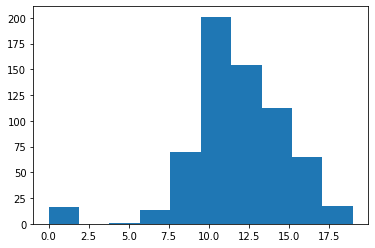

In [76]:
#Agora vamos avaliar se existem outliers, avaliando a distribuição dos nossos dados
plt.hist(por['G3'], alpha = 1, label='Original Data')
por['G3'].shape

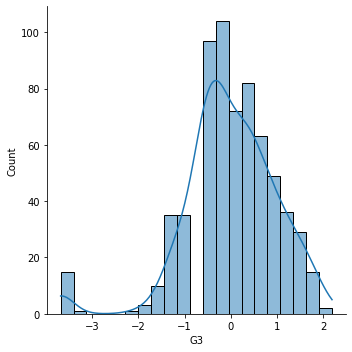

In [77]:
#Agora faremos uma normalização dos dados para poder aplicar a regrade trimming and censoring
por['G3'] = (por['G3'] - por['G3'].mean())/por['G3'].std()
sns.displot(por['G3'], kde = True)

In [78]:
#Aqui vou definir o limite tanto para cima quanto para baixo
n_mat = 2

upper_limit = por['G3'].mean() + n_mat*por['G3'].std()
lower_limit = por['G3'].mean() - n_mat*por['G3'].std()

In [79]:
#TRIMMING

por_trimmed = por[
    (por['G3'] < upper_limit) &
    (por['G3'] > lower_limit)
]

por_trimmed.shape

#CENSORING

por_censored = pd.DataFrame()

por_censored['G3'] =  np.where(
    por['G3'] > upper_limit,
        upper_limit,
        np.where(
            por['G3'] < lower_limit,
            lower_limit,                   
            por['G3']               
            )
        )

por_censored.shape

(649, 1)

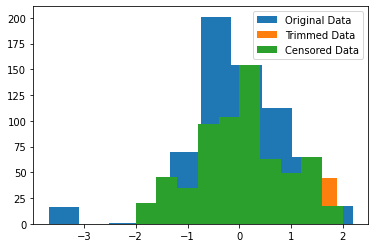

In [80]:
plt.hist(por['G3'], alpha=1, label='Original Data')
plt.hist(por_trimmed['G3'], alpha = 1, label='Trimmed Data')
plt.hist(por_censored['G3'], alpha=1, label = 'Censored Data')

plt.legend(loc='upper right')
plt.show()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,11.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,11.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,12.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,14.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,no,5,4,2,1,2,5,4,10.0
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,no,4,3,4,1,1,1,4,16.0
646,MS,F,18,U,GT3,T,1,1,other,other,...,no,no,1,1,1,1,1,5,6,9.0
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,6,10.0


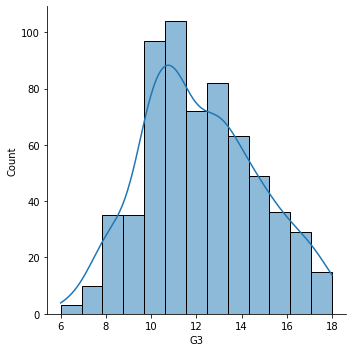

In [81]:
# "(Des)normalizando"
por_n = por_trimmed
por_n['G3'] = por_n['G3']* por_std['G3'] + por_mean['G3']

sns.displot(por_n['G3'], kde = True)
por_n

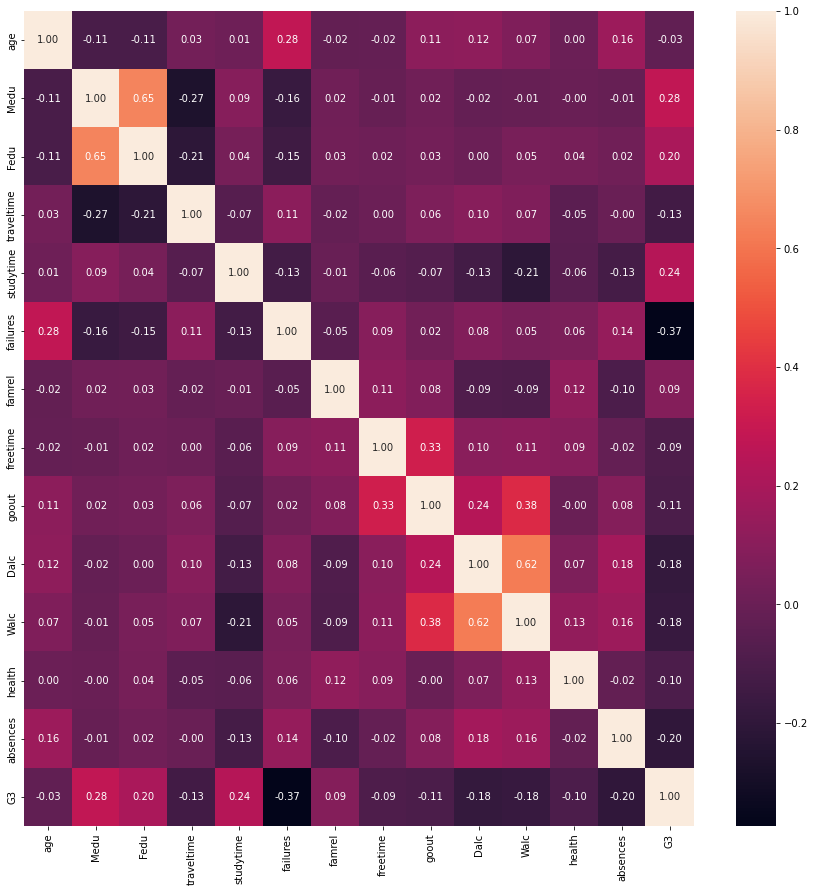

In [82]:
plt.figure(figsize=(15,15))
sns.heatmap(por_n.corr(),annot = True,fmt = ".2f",cbar = True)

In [83]:
#Para avaliar os efeitos do consumo de alcool, primeiro vou juntar as variaveis de consumo durante a semana e durante o final de semana, por_nque se eu avalair separadamente posso ter problemas de cofounder variables
por_n['alc'] = por_n['Dalc'] + por_n['Walc']

#Agora vou rodar a regressão linear para medir os efeitos do alcool nas notas, vou incluir ainda variaveis como tempo de estudo, idade, e educação dos país
X = por_n[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = por_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     39.42
Date:                Sun, 15 May 2022   Prob (F-statistic):           3.16e-35
Time:                        20:39:14   Log-Likelihood:                -1413.7
No. Observations:                 630   AIC:                             2839.
Df Residuals:                     624   BIC:                             2866.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9853      0.385     28.511      0.000      10.229      11.742
alc           -0.1920      0.047     -4.047      0.000      -0.285      -0.099
Medu           0.4432      0.107      4.155      0.000       0.234       0.653
Fedu           0.0714      0.110      0.652      0.515      -0.144       0.287
failures      -1.4196      0.164     -8.639      0.000      -1.742      -1.097
studytime      0.4832      0.113      4.263      0.000       0.261       0.706
==============================================================================
Omnibus:                        4.692   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                4.773
Skew:                           0.199   Prob(JB):                       0.0920
Kurtosis:                       2.847   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Em Português os efeitos são diferentes, a educação dos familiares tem um peso muito pequeno, o tempo de estudo tem um impacto maior. O uso de alcool por sua vez, tem um impacto bem mais significante quando comparado com matemática, enquanto ter falhado em outras matérias tem um peso um pouco menor mas permanece robusto e negativo.

In [84]:
## De semana
X = por_n[["Dalc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente 
y = por_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     38.87
Date:                Sun, 15 May 2022   Prob (F-statistic):           8.85e-35
Time:                        20:39:14   Log-Likelihood:                -1414.8
No. Observations:                 630   AIC:                             2842.
Df Residuals:                     624   BIC:                             2868.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7885      0.367     29.403      0.000      10.068      11.509
Dalc          -0.3865      0.102     -3.773      0.000      -0.588      -0.185
Medu           0.4527      0.107      4.238      0.000       0.243       0.662
Fedu           0.0539      0.110      0.492      0.623      -0.161       0.269
failures      -1.4123      0.165     -8.574      0.000      -1.736      -1.089
studytime      0.5176      0.112      4.606      0.000       0.297       0.738
==============================================================================
Omnibus:                        4.889   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.975
Skew:                           0.204   Prob(JB):                       0.0831
Kurtosis:                       2.850   Cond. No.                         18.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
## De fim de semana
X = por_n[["Walc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente 
y = por_n["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     38.43
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.03e-34
Time:                        20:39:14   Log-Likelihood:                -1415.6
No. Observations:                 630   AIC:                             2843.
Df Residuals:                     624   BIC:                             2870.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8474      0.381     28.436      0.000      10.098      11.596
Walc          -0.2605      0.074     -3.538      0.000      -0.405      -0.116
Medu           0.4406      0.107      4.116      0.000       0.230       0.651
Fedu           0.0755      0.110      0.686      0.493      -0.141       0.291
failures      -1.4344      0.165     -8.709      0.000      -1.758      -1.111
studytime      0.4873      0.114      4.272      0.000       0.263       0.711
==============================================================================
Omnibus:                        4.199   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.275
Skew:                           0.187   Prob(JB):                        0.118
Kurtosis:                       2.849   Cond. No.                         20.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Já para português, o consumo de álcool, tem um efeito negativo independente do dia, mas pior se beber durante a semana.

In [86]:
#Como fiz em matemática, farei em PT também:
por1 = pd.get_dummies(por_n, columns=['sex', 'school'])

In [87]:
X = por1[["alc", "Medu", "Fedu", "failures", "studytime", "sex_M", "sex_F", "school_GP", "school_MS"]] ## VAR Independente
y = por1["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto

# Modelando
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)

# Resultados
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     31.57
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.63e-37
Time:                        20:39:14   Log-Likelihood:                -1404.4
No. Observations:                 630   AIC:                             2825.
Df Residuals:                     622   BIC:                             2860.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4954      0.195     28.234      0.000       5.113       5.878
alc           -0.1598      0.049     -3.252      0.001      -0.256      -0.063
Medu           0.4033      0.107      3.758      0.000       0.193       0.614
Fedu           0.0493      0.108      0.456      0.649      -0.163       0.262
failures      -1.3680      0.163     -8.410      0.000      -1.687      -1.049
studytime      0.4030      0.114      3.537      0.000       0.179       0.627
sex_M          2.5393      0.152     16.709      0.000       2.241       2.838
sex_F          2.9561      0.126     23.467      0.000       2.709       3.203
school_GP      3.1449      0.146     21.573      0.000       2.859       3.431
school_MS      2.3505      0.133     17.607      0.000       2.088       2.613
==============================================================================
Omnibus:                        6.770   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.903
Skew:                           0.245   Prob(JB):                       0.0317
Kurtosis:                       2.850   Cond. No.                     3.50e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.76e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Eu não acho que os efeitos medidos com a dummies de sexo e escola signifiquem efeitos verdadeiros, tanto em mat quanto em por, talvez se eu filtrasse os dataset e rodasse as regressões conseguiria medir de uma forma mais acurada. 


## Aqui também farei um recorte nos dados para POR

In [88]:
por_m = por_n.query('sex == "M"')
por_f = por_n.query('sex == "F"')
por_gp = por_n.query('school == "GP"')
por_ms = por_n.query('school == "MS"')

In [89]:
X = por_m[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = por_m["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.47
Date:                Sun, 15 May 2022   Prob (F-statistic):           8.02e-15
Time:                        20:39:15   Log-Likelihood:                -560.39
No. Observations:                 255   AIC:                             1133.
Df Residuals:                     249   BIC:                             1154.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9443      0.585     20.426      0.000      10.793      13.096
alc           -0.3085      0.061     -5.036      0.000      -0.429      -0.188
Medu           0.2534      0.162      1.566      0.119      -0.065       0.572
Fedu           0.1803      0.161      1.118      0.265      -0.137       0.498
failures      -1.0808      0.215     -5.022      0.000      -1.505      -0.657
studytime      0.2287      0.170      1.344      0.180      -0.106       0.564
==============================================================================
Omnibus:                        4.887   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.575
Skew:                           0.315   Prob(JB):                        0.102
Kurtosis:                       3.186   Cond. No.                         27.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
X = por_f[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = por_f["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sun, 15 May 2022   Prob (F-statistic):           7.97e-22
Time:                        20:39:15   Log-Likelihood:                -841.28
No. Observations:                 375   AIC:                             1695.
Df Residuals:                     369   BIC:                             1718.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9873      0.521     19.170      0.000       8.963      11.012
alc            0.0250      0.082      0.305      0.760      -0.136       0.186
Medu           0.5562      0.141      3.941      0.000       0.279       0.834
Fedu           0.0185      0.145      0.127      0.899      -0.267       0.304
failures      -1.7732      0.244     -7.253      0.000      -2.254      -1.292
studytime      0.6406      0.151      4.229      0.000       0.343       0.938
==============================================================================
Omnibus:                        2.867   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.446
Skew:                           0.095   Prob(JB):                        0.294
Kurtosis:                       2.652   Cond. No.                         24.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
X = por_gp[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = por_gp["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     19.04
Date:                Sun, 15 May 2022   Prob (F-statistic):           4.75e-17
Time:                        20:39:15   Log-Likelihood:                -926.70
No. Observations:                 419   AIC:                             1865.
Df Residuals:                     413   BIC:                             1890.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4456      0.494     23.156      0.000      10.474      12.417
alc           -0.1432      0.057     -2.508      0.013      -0.255      -0.031
Medu           0.3827      0.131      2.919      0.004       0.125       0.641
Fedu          -0.0265      0.129     -0.206      0.837      -0.280       0.227
failures      -1.2580      0.215     -5.856      0.000      -1.680      -0.836
studytime      0.4694      0.135      3.475      0.001       0.204       0.735
==============================================================================
Omnibus:                        2.658   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.714
Skew:                           0.170   Prob(JB):                        0.257
Kurtosis:                       2.799   Cond. No.                         27.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
X = por_ms[["alc", "Medu", "Fedu", "failures", "studytime"]] ## VAR Independente
y = por_ms["G3"] ## VAR dependente
X = sm.add_constant(X) ## adicionando um intercepto
model = sm.OLS(y, X).fit() ## 
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     15.29
Date:                Sun, 15 May 2022   Prob (F-statistic):           9.11e-13
Time:                        20:39:15   Log-Likelihood:                -476.73
No. Observations:                 211   AIC:                             965.5
Df Residuals:                     205   BIC:                             985.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9629      0.629     17.422      0.000       9.722      12.204
alc           -0.2950      0.083     -3.562      0.000      -0.458      -0.132
Medu           0.3614      0.186      1.945      0.053      -0.005       0.728
Fedu           0.2537      0.202      1.253      0.211      -0.145       0.653
failures      -1.5902      0.255     -6.225      0.000      -2.094      -1.087
studytime      0.3792      0.208      1.825      0.069      -0.030       0.789
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.433
Skew:                           0.301   Prob(JB):                        0.180
Kurtosis:                       2.835   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Olhando apenas R2 nenhum desses parece ter um fit muito bom com o modelo escolhido